In [179]:
%reset -f

## Lets import some useful packages

In [180]:
import warnings
warnings.filterwarnings("ignore")
import random
from copy import deepcopy as dp

import numpy as np
import pandas as pd

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, TensorBoard
from keras.initializers import RandomNormal as RN
from keras.utils.vis_utils import model_to_dot



from utils import *


from tqdm import *
import os 
from os import system
from PIL import Image
from IPython.display import SVG
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn.metrics import accuracy_score, f1_score

## Some parameters

In [181]:
size = 128
data_train_path_target = "data_airbus_defi/train/"
data_test_path = "data_airbus_defi/test/"
input_shape = (size, size, 3)

## Loading data. Numpy arrays

In [182]:
PATH = os.getcwd()

###############
# SIZE LOADED #
###############

full = False
some = True
if full:
    training_size = float("inf")
    testing_size = float("inf")
elif some:
    training_size = 5000
    testing_size = float("inf")
else:
    training_size = 10
    testing_size = 10
    

    
#########
# TRAIN #
#########

train_path = PATH +"/" + data_train_path_target + "target/"
train_data_target = os.listdir(train_path)
x_train = []
tdt = 0
for sample in (train_data_target):
    img_path = train_path+sample
    x = image.load_img(img_path)
    x_train.append(np.array(x))
    tdt += 1
    if tdt > training_size:
        break

train_path = PATH +"/" + data_train_path_target + "other/"
train_data_other = os.listdir(train_path)
x_train2 = []
tdo = 0
for sample in (train_data_other):
    img_path = train_path+sample
    x = image.load_img(img_path)
    # preprocessing if required
    x_train2.append(np.array(x))
    tdo += 1
    if tdo > training_size:
        break

        
########
# TEST #
########

test_path = PATH+'/data_airbus_defi/test/'
test_data = os.listdir(test_path)
x_test = []
td = 0
output = pd.DataFrame(columns=["name"])
test_data = [str(x) + ".jpg" for x in range(len(test_data))]
for sample in (test_data):
    output.append({"name": sample},ignore_index=True)
    #print(sample)
    img_path = test_path+sample
    x = image.load_img(img_path)
    # preprocessing if required
    x_test.append(np.array(x))
    td+=1
    if td > testing_size:
        break
    

# finally converting list into numpy array
x_train = np.array(x_train)
x_train2 = np.array(x_train2)
x_test = np.array(x_test) / 255.
XTRAIN = np.concatenate((x_train, x_train2), axis=0) / 255.

In [183]:
system('say Data chargée!')

0

In [184]:
print("Input data shape")
print(x_train.shape)
print(x_train2.shape)
print(XTRAIN.shape)

Input data shape
(5001, 128, 128, 3)
(5001, 128, 128, 3)
(10002, 128, 128, 3)


## Lablelling data

In [185]:
train_label1 = np.array([1] * x_train.shape[0] + [0] * x_train2.shape[0])

## Suffling data
Not (totally) sure it is useful. As Keras might do it itself

Quite long when we use every data

In [186]:
XTRAIN, train_labels = unison_shuffled_copies(XTRAIN,train_label1)

In [187]:
system('say Data mélangée!')

0

## Useful (?) functions

In [188]:
def soumissionCSV(prediction, name):
    global test_data
    X = pd.DataFrame()
    X["name"] = test_data
    X["prediction"] = prediction
    X.set_index("name", inplace=True)
    X.to_csv("soumissions/"+name + ".csv", sep=";")
    print("CSV file written")

def prediction_from_model(model):
    global x_test
    pred = model.predict(x_test)
    prediction = [cut_half(x) for x in pred]
    print("some predictions")
    print(prediction[:9])
    return prediction

## Model generator

In [189]:
def cnn(n_layers, MIN_NEURONS=12, MAX_NEURONS=32, KERNEL=(3,3)):
    global input_shape
    # Determine the # of neurons in each convolutional layer
    steps = np.floor(MAX_NEURONS / (n_layers + 1))
    nuerons = np.arange(MIN_NEURONS, MAX_NEURONS, steps)
    nuerons = nuerons.astype(np.int32)

    model = Sequential()
    for i in range(0, n_layers):
        if i == 0:
            model.add(Conv2D(nuerons[i], KERNEL, input_shape=input_shape))
        else:
            model.add(Conv2D(nuerons[i], KERNEL))

        model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(MAX_NEURONS))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [190]:
modelCNN = cnn(3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 126, 126, 12)      336       
_________________________________________________________________
activation_11 (Activation)   (None, 126, 126, 12)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 124, 124, 20)      2180      
_________________________________________________________________
activation_12 (Activation)   (None, 124, 124, 20)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 122, 122, 28)      5068      
_________________________________________________________________
activation_13 (Activation)   (None, 122, 122, 28)      0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 61, 61, 28)        0         
__________

## The model. Finally !

In [191]:
trained = False

epochs = 5
validation_split = .1
conv2Dsize = 32
pool_size = (3,3)
fulSize = 16
dropout = .5

if not trained:
    modelBW = Sequential()
    modelBW.add(Conv2D(conv2Dsize, (4,4), input_shape = input_shape, activation = 'relu'))
    modelBW.add(Conv2D(12, pool_size, activation = 'relu'))
    modelBW.add(Conv2D( 6, (2,2), activation = 'relu'))
    modelBW.add(MaxPooling2D(pool_size = (2,2)))
    modelBW.add(Dropout(dropout))
    modelBW.add(Conv2D(conv2Dsize, (3, 3), activation = 'relu'))
    modelBW.add(MaxPooling2D(pool_size = pool_size))
    modelBW.add(Dropout(dropout))
    modelBW.add(Flatten())
    modelBW.add(Dense(units = fulSize, activation = 'sigmoid'))
    modelBW.add(Dense(units = 1, activation = 'sigmoid'))

    modelBW.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    modelBW.summary()
else:
    modelBW = loadModel("2018-11-06 13:52")
    modelBW.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    modelBW.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 125, 125, 32)      1568      
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 123, 123, 12)      3468      
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 122, 122, 6)       294       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 61, 61, 6)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 61, 61, 6)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 59, 59, 32)        1760      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 19, 19, 32)        0         
__________

## Learning

In [193]:
history = modelBW.fit(XTRAIN, train_labels, epochs=epochs, verbose=1, validation_split=validation_split, batch_size=16)
# What about batch_size
# Change maxpooling
#

Train on 9001 samples, validate on 1001 samples
Epoch 1/5
9001/9001 [==============================] - 337s 37ms/step - loss: 0.3444 - acc: 0.8677 - val_loss: 0.2778 - val_acc: 0.8921
Epoch 2/5
9001/9001 [==============================] - 310s 34ms/step - loss: 0.2522 - acc: 0.9037 - val_loss: 0.2799 - val_acc: 0.8871
Epoch 3/5
9001/9001 [==============================] - 302s 34ms/step - loss: 0.2232 - acc: 0.9146 - val_loss: 0.2102 - val_acc: 0.9161
Epoch 4/5
9001/9001 [==============================] - 60637s 7s/step - loss: 0.2022 - acc: 0.9250 - val_loss: 0.2104 - val_acc: 0.9171
Epoch 5/5
9001/9001 [==============================] - 436s 48ms/step - loss: 0.1903 - acc: 0.9287 - val_loss: 0.2058 - val_acc: 0.9291


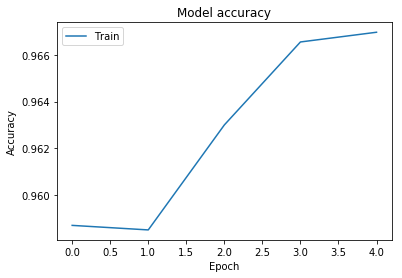

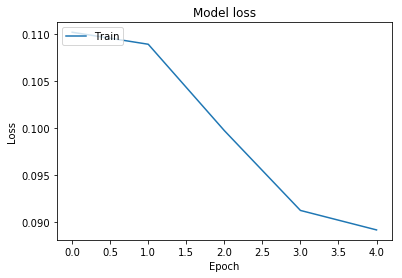

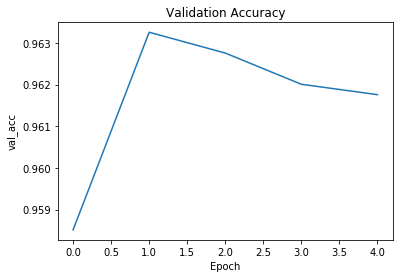

In [41]:
plotLearning(history)

## Prediction

In [42]:
prediction = prediction_from_model(modelBW)

some predictions
[1, 0, 1, 0, 1, 1, 0, 1, 1]


## Writting output

In [150]:
today = str(datetime.today())[:16]
soumissionCSV(prediction, today)

CSV file written


In [44]:
system('say On est bon!')

0

In [45]:
print("Proportion of windmills")
sum(prediction)/ len(prediction)

Proportion of windmills


0.48458020637898686

In [151]:
saveModel(modelBW, today)

Saved model


## Improving model

In [144]:
size = 1000
Xviz = XTRAIN[-size:]
p= modelBW.predict(Xviz)
pr = [cut_half(x) for x in p]
lab = train_labels[-size:]

In [145]:
Xviz.shape[0]

1000

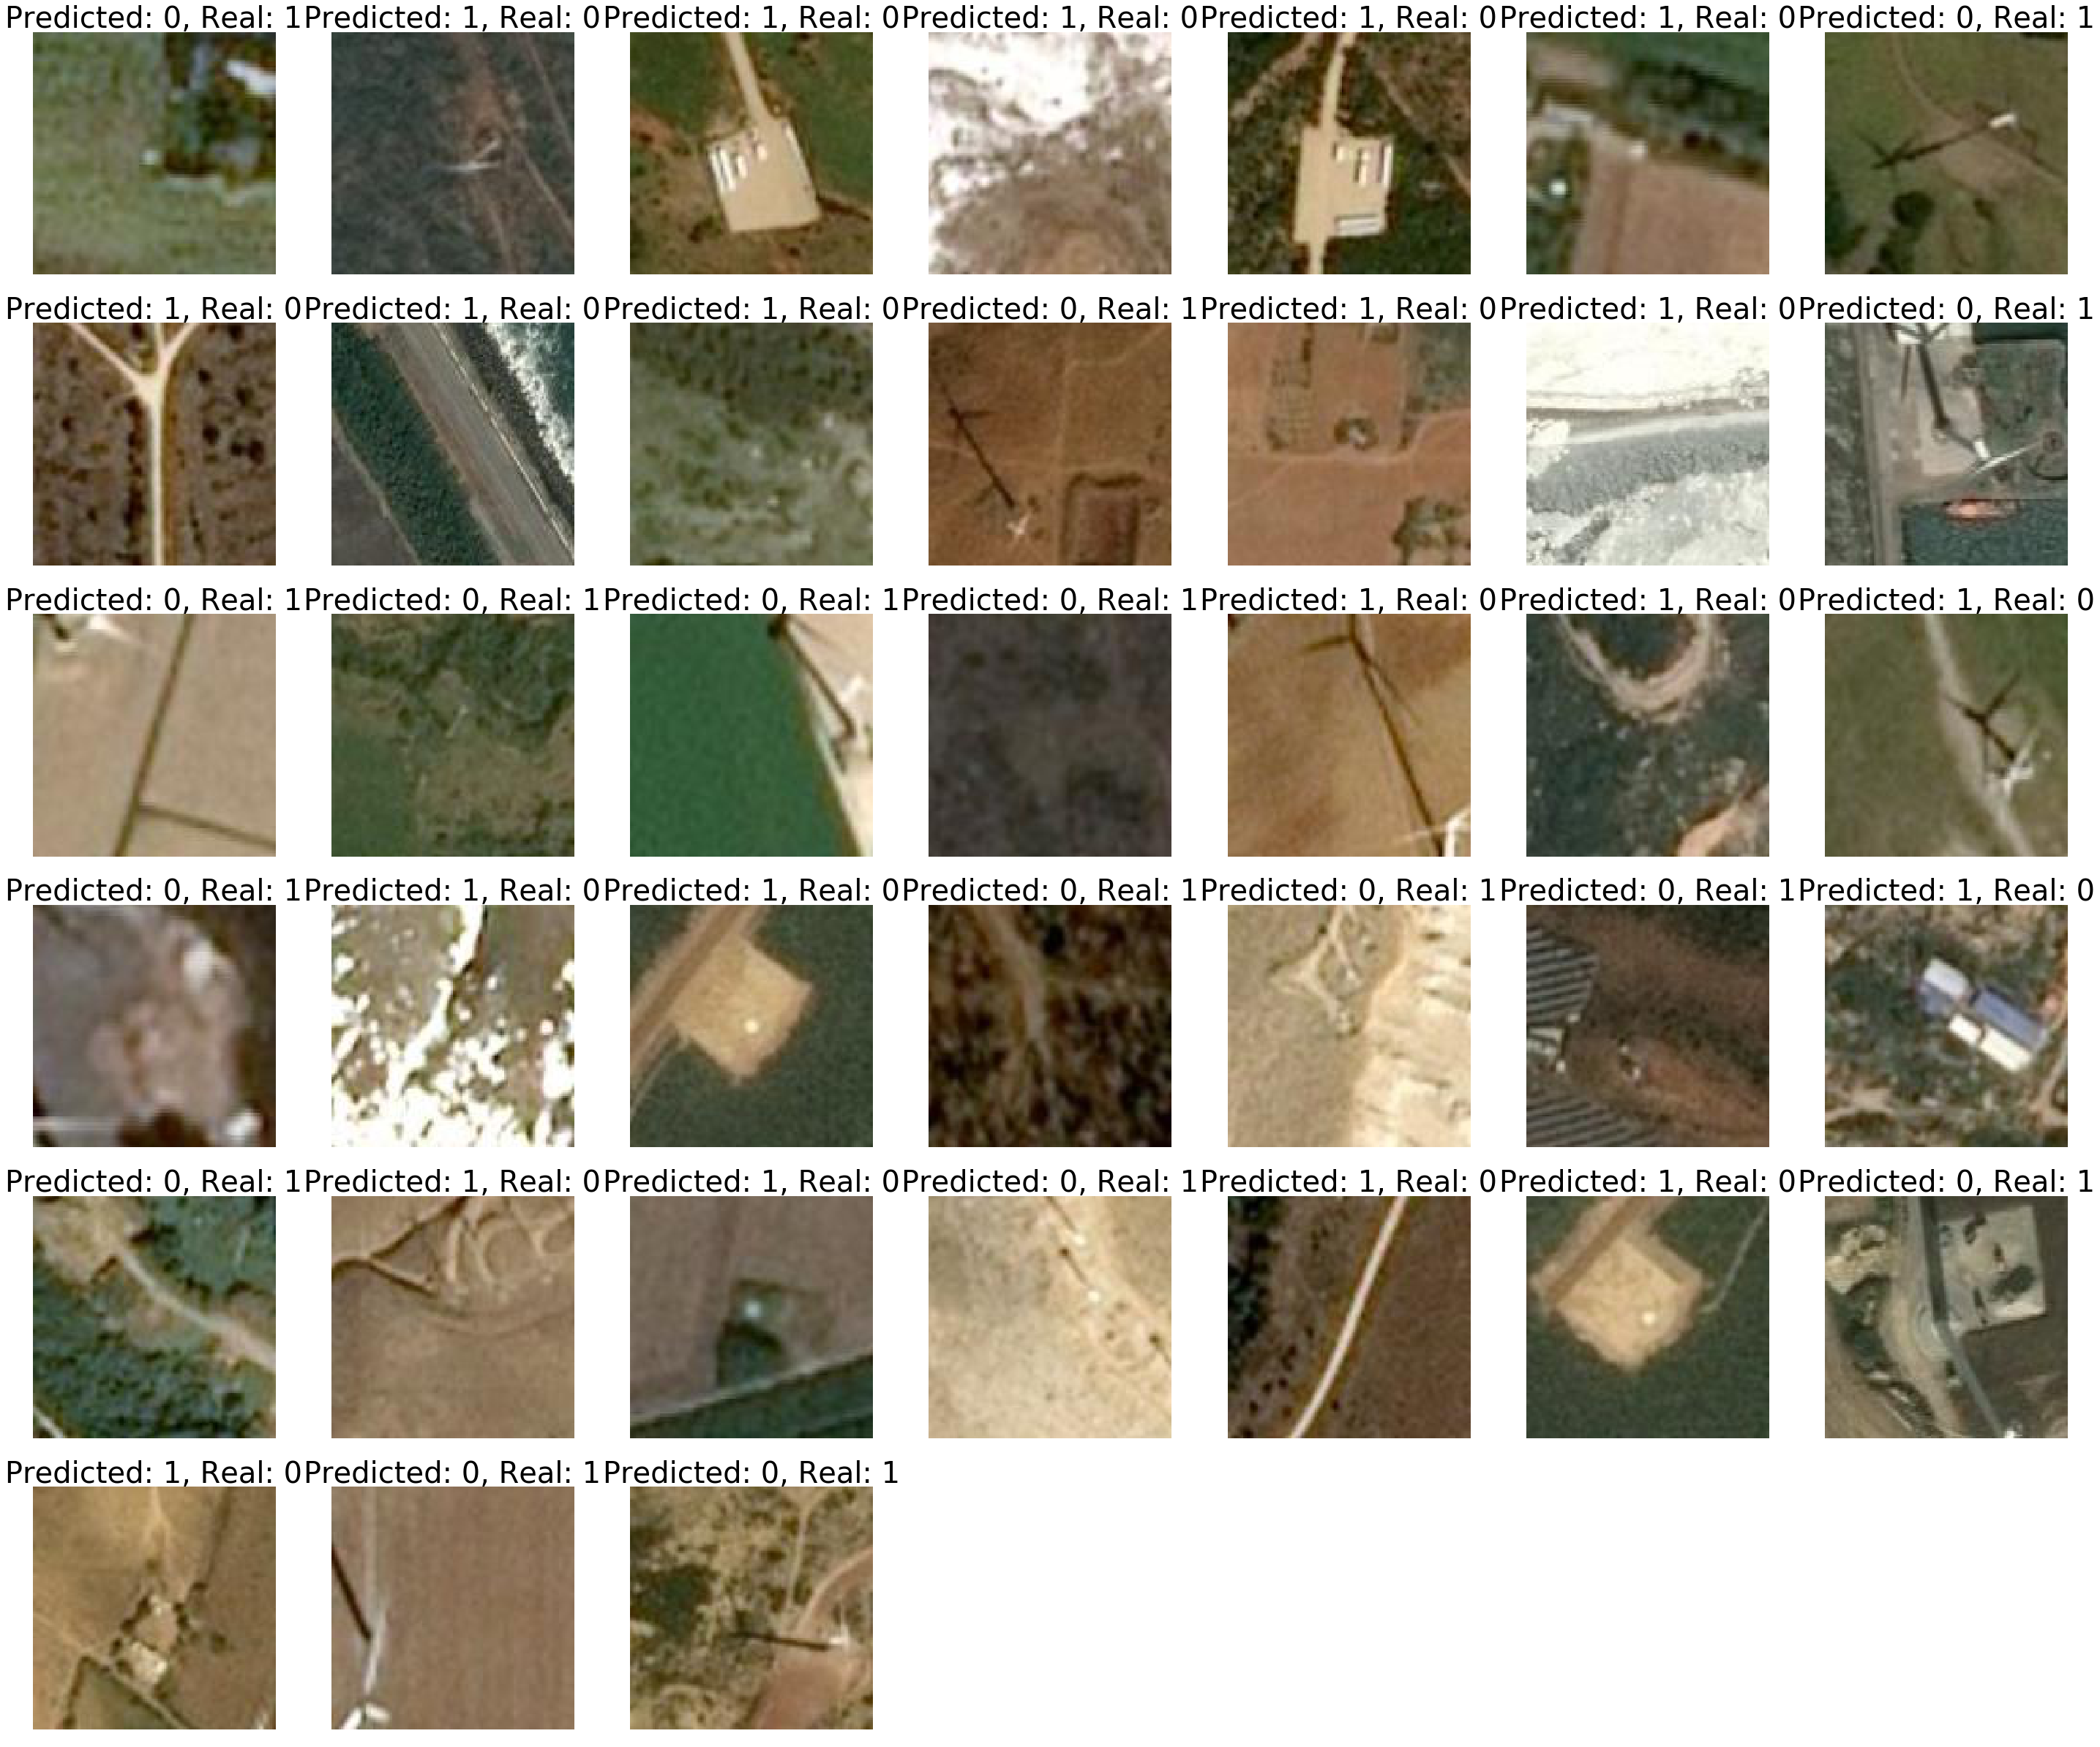

In [146]:
visualize_incorrect_labels(Xviz, lab, np.array(pr))

---------

## Loading old models

In [166]:
loadedModel = loadModel("2018-11-06 13:52")
pred = prediction_from_model(loadedModel)

Loaded model from disk
some predictions
[1, 0, 1, 0, 1, 1, 0, 1, 1]


-------

## One model that was good

In [ ]:
epochs = 50
validation_split = .1
conv2Dsize = 12
pool_size = (2,2)


modelBW = Sequential()
modelBW.add(Conv2D(conv2Dsize, (5), 
                  padding="same", 
                  input_shape=input_shape))
modelBW.add(Activation("relu"))
modelBW.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2)))

# second set of CONV => RELU => POOL layers
modelBW.add(Conv2D(conv2Dsize, (5, 5), padding="same"))
modelBW.add(Activation("relu"))
modelBW.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2)))
#model.add(Dropout(0.2)) ???



#first (and only) set of FC => RELU layers
modelBW.add(Flatten())
modelBW.add(Dense(2))
modelBW.add(Activation("sigmoid"))

# softmax classifier
modelBW.add(Dense(1))
modelBW.add(Activation("relu"))
modelBW.compile(loss='mse',
              optimizer='rmsprop',
              metrics=['accuracy'])



## Random Search to tune hyperparameters

In [ ]:
def windmill_model(x_train, y_train, x_val, y_val, params):

    
    
    modelBW = Sequential()
    modelBW.add(Conv2D(conv2Dsize, (4,4), input_shape = input_shape, activation = params['activation']))
    modelBW.add(Conv2D(12, pool_size, activation = params['activation']))
    modelBW.add(Conv2D( 6, (2,2), activation = 'relu'))
    modelBW.add(MaxPooling2D(pool_size = (2,2)))
    modelBW.add(Dropout(params['dropout']))
    modelBW.add(Conv2D(conv2Dsize, (3, 3), activation = 'relu'))
    modelBW.add(MaxPooling2D(pool_size = pool_size))
    modelBW.add(Dropout(params['dropout']))
    modelBW.add(Flatten())
    modelBW.add(Dense(units = params["hidden_layers"], activation = 'sigmoid'))
    modelBW.add(Dense(units = 1, activation = 'sigmoid'))

    model.compile(loss=params['losses'],
                  optimizer=params['optimizer'](lr=lr_normalizer(params['lr'],params['optimizer'])),
                  metrics=['acc', fmeasure])    # next we can build the model exactly like we would normally do it
    model = Sequential()
    model.add(Dense(10, input_dim=x_train.shape[1],
                    activation=params['activation'],
                    kernel_initializer='normal'))
    
    model.add(Dropout(params['dropout']))
    
    # if we want to also test for number of layers and shapes, that's possible
    hidden_layers(model, params, 1)
   
    # then we finish again with completely standard Keras way
    model.add(Dense(1, activation=params['last_activation'],
                    kernel_initializer='normal'))
    
    model.compile(loss=params['losses'],
                  # here we add a regulizer normalization function from Talos
                  optimizer=params['optimizer'],
                  metrics=['acc', fmeasure])
    
    history = model.fit(x_train, y_train, 
                        validation_split=.1,
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=0)
    
    # finally we have to make sure that history object and model are returned
    return history, modelBW

In [ ]:
p = {'lr': (1),
     'first_neuron':[4, 8, 16, 32, 64],
     'hidden_layers':[0, 1, 2],
     'batch_size': (2, 30, 10),
     'epochs': [5],
     'dropout': (0, 0.5, 5),
     'weight_regulizer':[None],
     'emb_output_dims': [None],
     'shape':['brick','long_funnel'],
     'optimizer': ["adam", "SGD", "RMSprop"],
     'losses': ["logcosh", "binary_crossentropy"],
     'activation':["relu", "softmax"],
     'last_activation': ["sigmoid"]}

## Maybe we can use Tensorboard to vizualize learning ?



In [ ]:
"""
PATIENCE = 10
early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=PATIENCE, verbose=0, mode='auto')
LOG_DIRECTORY_ROOT = ''
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
log_dir = "TF" + now
tensorboard = TensorBoard(log_dir=log_dir, write_graph=True, write_images=True)
callbacks = [early_stopping, tensorboard]
model.fit(XTRAIN, train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, verbose=0)
"""